# CH8_Attention
> 앞 장에서 RNN을 사용해 문장을 생성해봤다. 그리고 2개의 RNN을 연결하여 하나의 시계열 데이터를 다른 시계열 데이터로 변화해 봤다. 우리는 이를 seq2seq라고 한다. <br> 이번 장에서는 seq2seq의 가능성 그리고 RNN의 가능성을 한걸음 더 깊이 탐험할 것이다. 어텐션이다. 어텐션은 최근 딥러닝 분야에서 틀림없이 주용한 기술중 하나이다.

## 1. 어텐션 구조
> 어텐션이라는 메커니즘 덕분에 seq2seq는 필요한 정보에만 주목할 수 있게 된다. 게다가 지금까지의 seq2seq가 안고 있던 문제도 해결할 수 있다. 그래서 가장 먼저 seq2seq의 문제를 살펴보고 어텐션의 구조를 설명 및 구현을 할 예정이다.

### 1) seq2seq의 문제점
> seq2seq에서는 Encoder가 시계열 데이터를 인코딩한다. 그리고 인코딩된 정보를 Decoder로 전달한다. 이때 Encoder의 출력은 '고정 길이의 벡터'였다. 그런데 실은 이 '고정 길이'라는 데에 큰 문제가 잠재해 있다.

- 고정 길이 벡터라 함은 입력 문장의 길이에 관계없이(아무리 길어도), 항상 같은 길이의 벡터로 변환한다는 뜻이다.
- 앞 장의 번역 예로 설명하면 아무리 긴 문장이 입력되더라도 항상 똑같은 길이의 벡터에 밀어 넣어야 한다. 

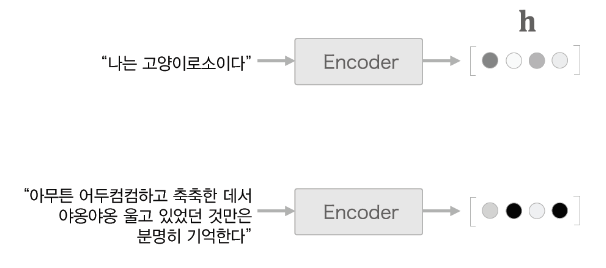

- 현재의 Encoder는 아무리 긴 문장이라도 고정 길이 벡터로 변환한다. 마치 많은 옷가지를 옷장에 욱여넣듯이 억지로 고정 길이의 벡터로 밀어 넣는 것이다.
- 하지만 이렇게 하면 곧 한계가 찾아온다. 결국에는 옷이 옷장에서 빠져나오듯, 필요한 정보가 벡터에 다 담기지 못하게 된다.

### 2) Encoder 개선

> 지금까지는 LSTM 계층의 마지막 은닉 상태만 Decoder에 전달했다. 그러나 Encoder 출력의 길이는 문장의 길이에 따라 바꿔주는 것이 좋다. 이 점이 Encoder의 개선 포인트이다. 구체적으로는 아래의 그림과 같이 시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것이다.

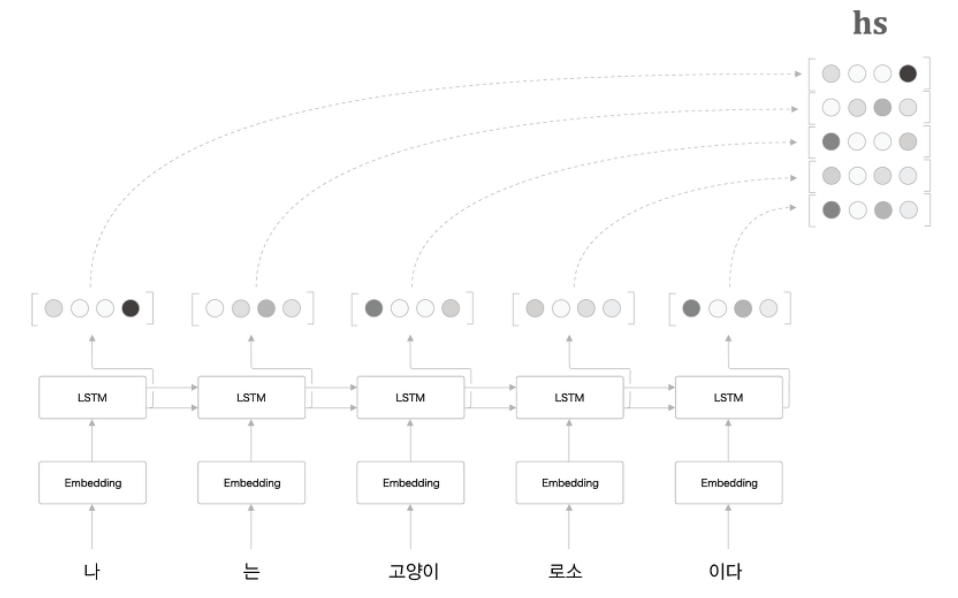

- 각 시각(각 단어)의 은닉 상태 벡터를 모두 이용하면 입력된 단어와 같은 수의 벡터를 얻을 수 있다.
- 여기에서 주목할 것은 LSTM 계층의 은닉 상태의 내용이다. 시각별 LSTM 계층의 은닉 상태에는 어떠한 정보가 담겨져 있을가? 한 가지 말할 수 있는 것은 각 시각의 은닉 상태에는 직전에 입력된 단어에 대한 정보가 많이 포함되어 있다는 사실이다.
- 이렇게 생각하면 Encoder가 출력하는 hs행렬은 각 단어에 해당하는 벡터들의 집합이라고 볼 수 있다.
- Encoder의 은닉 상태를 모든 시각만큼 꺼낸다. 이 작은 개선 덕분에 Encoder는 문장의 길이에 비례한 정보를 인코딩 할 수 있게 되었다.

### 3) Decoder 걔선_1

> Encoder는 각 단어에 대응하는 LSTM 게층의 은닉 상태 벡터를 hs로 모아 출력한다. 그리고 이 hs가 Decoder에 전달되어 시계열 변호나이 이뤄진다. 참고로, 앞 장에서 본 가장 단순한 seq2seq에서는 Encoder의 마지막 은닉 상태벡터만을 Decoder에 넘겼다. 더 정확하게 말하자면 Encoder의 LSTM 계층의 마지막 은닉 상태를 Decoder의 LSTM 계층의 첫 은닉 상태로 설정한 것이다. 이 hs를 전부 활용할 수 있도록 Decoder를 개선해보겠다.

- 앞으로 우리의 목표는 도착어 단어와 대응 관계에 있는 출발어 단어 정보를 골라내는 것이다. 그리고 그 정보를 이용하여 번역을 수행하는 것이다.
- 다시 말해 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표이다. 이 구조를 어텐션이라고 부른다.

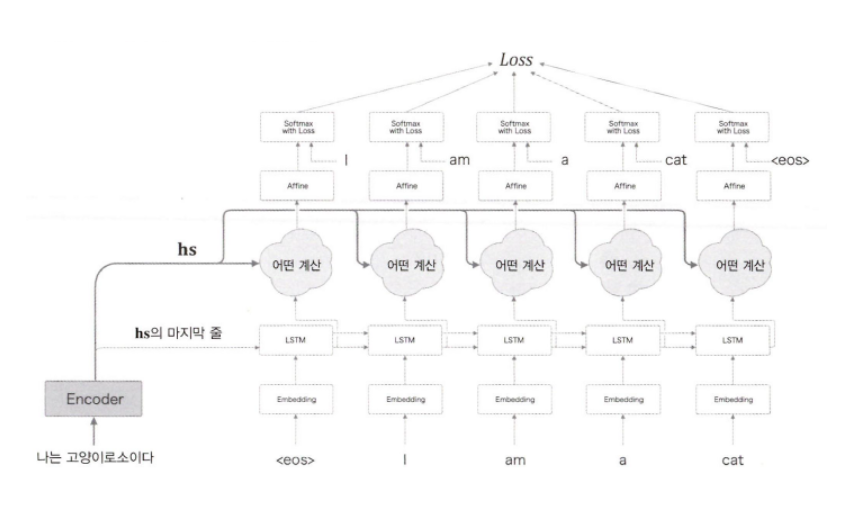

- 위의 그림에서 어떤 계산을 수행하는 계층을 추가할 것이다. 이 어떤 계산이 받는 입력은 두가지이다.
    - Encoder로부터 받는 hs
    - 시각별 LSTM 계층의 은닉 상태
- 그리고 여기에 필요한 정보만 골라 위쪽 Affine 계층으로 출력한다. 참고로, 지금까지 똑같이 Encoder의 마지막 은닉상태 벡터는 Decoder의 첫번째 LSTM 계층에 전달한다.
- 그런데 위의 그림의 신경망으로 하고 싶은 일은 단어들의 얼라인먼트(단어의 대응 관계를 나타내는 정보) 추출이다.
- 각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 hs에 골라내겠다는 뜻이다.
- 예컨대 Decoder에서 'I'를 출력할 때 hs에서 '나'에 대응하는 벡터를 선택하면 된다. 그리고 이러한 선택 작업을 어떤 계산으로 해내겠다는 것이다.
- 하지만 여기에서 문제가 발생한다. 바로 선택하는 작업을 미분할 수 없다.
    - 이 문제를 해결하기 위한 아이디어는 간단하다 하나를 선택 하는 것이 아니라 '모든 것을 선택'한다는 것이다.
    - 그리고 아래의 그림처럼 각 단어의 중요도를 나타내는 가중치를 별도로 계산하도록 한다.

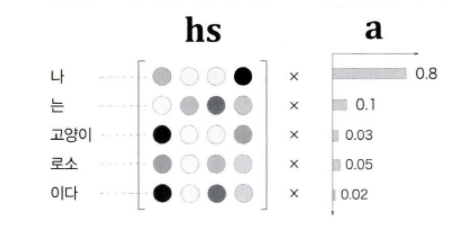

- 위의 그림에서 보듯이 각 단어의 중요도를 나타내는 가중치를 이용한다.
- a는 확률분포처럼 각 원소가 0.0~1.0사이의 스칼라(단일 원소)이며, 
- 모든 원소의 총합은 1이 된다.
- 그리고 각 단어의 중요도를 나타내는 가중치 a와 각 단어이 벡터 hs로부터 가중합을 구하여 우리가 원하는 벡터를 얻는다.

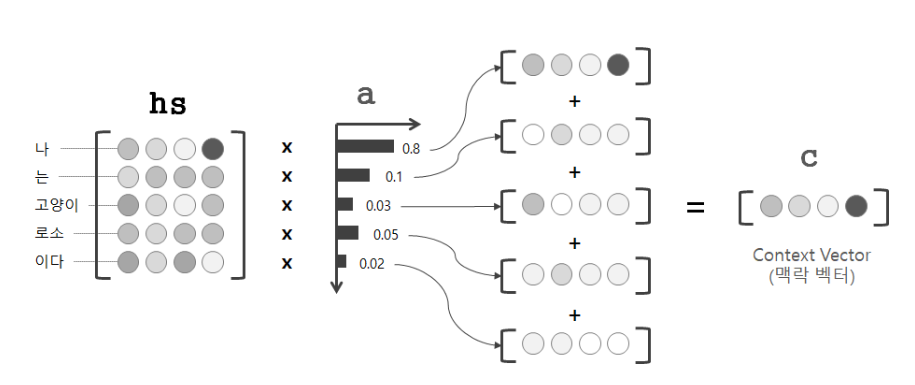

- 위 그림처럼 단어 벡터의 가중합을 계산한다. 
- 여기에서는 그 결과를 '맥락 벡터'라고 부르고, 기호로는 c로 표기한다.
- 그런데 이 그림을 잘 보면 '나'에 대응하는 가중치가 0.8이다. 이것이 의미하는 바는 맥락 벡터 c에는 "나" 벡터의 성분이 많이 포함되어 있다는 것이다.
- 즉, 벡터를 선택 하는 작업을 이 가중합으로 대체하고 있다고 볼 수 있다.

In [3]:
import numpy as np

T, H = 5, 4 # 길이를 5, 은닉 상태 벡터의 원소 수를 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


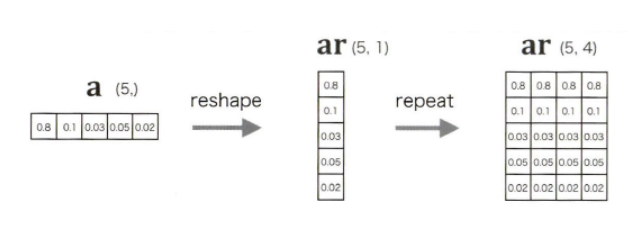

- 위 그림은 a.reshape(5,1).repeat(4, axis=1) 코드를 설명한 코드이다.
- 형상이 (5,)인 a를 복사하여, (5,4)짜리 배열을 만드는 것이다.
- 그래서 원래 형상이 (5,)인 afmf a.reshape(5,1)을 거쳐 (5,1) 형상으로 성형한 다음
- 이 배열의 한 축을 네 번 반복하여 형상이 (5,4)인 배열을 생성한다.
- 참고로, 여기에서는 repeat() 메서드 대신 넘파이의 브로드캐스트를 사용해도 된다.
- 즉 ar = a.reshape(5,1)까지만 한 뒤 고바로 hs*ar을 계산해도 된다. 이렇게 하면 hs의 형상과 일치하도록 ar이 자동으로 확장된다.

> 구현 효율을 생각하면 repeat() 메서드보다는 넘파이 브로드캐스트를 이용해야 할 것이다. 다만 이렇게 되면 다차원 배열의 원소가 복사 되고 있다는 점이 우리 눈에 보이지 않으니 유의하자 이 작업은 계산 그래프로는 Repeat 노드에 해당한다. 따라서 역전파 때는 Repeat노드의 역전파를 수행해야 한다.

In [4]:
N, T, H  = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N,T,1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


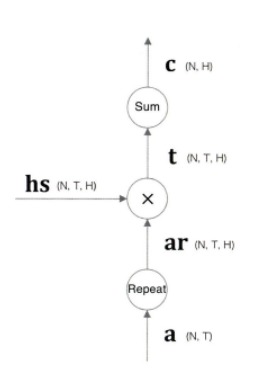

- Repeat 노드를 사용해 a를 복제한다.
- 이어서 'x' 노드로 원소별 곱을 계산한 다음
- sum 노드로 합을 구한다.

- Repeat의 역전파는 Sum이고
- Sum의 역전파는 Repeat이다.

In [5]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape

        dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeat의 역전파

        return dhs, da

### 4) Decoder 개선_2